In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torch
from torchvision import transforms

# Intensity thresholds (you can tweak later)
def label_map_from_image(image):
    mask = np.zeros_like(image, dtype=np.uint8)
    mask[(image > 0.05) & (image <= 0.2)] = 1  # Light
    mask[(image > 0.2) & (image <= 0.5)] = 2  # Moderate
    mask[image > 0.5] = 3                    # Heavy
    return mask

# RGB transform, normalize to [-1, 1]
transform_rgb = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),  # Converts to [0, 1]
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize to [-1, 1]
])

class PrecipSegDataset(Dataset):
    def __init__(self, image_dir):
        self.image_paths = sorted([
            os.path.join(image_dir, fname)
            for fname in os.listdir(image_dir)
            if fname.endswith('.png')
        ])
        self.transform = transform_rgb

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        filename = os.path.basename(path)
        date = filename.replace(".png", "")  # Extract date from filename

        image = Image.open(path).convert("RGB")
        image_tensor = self.transform(image)  # [3, 128, 128]

        # Generate segmentation label by averaging channels
        avg_intensity = image_tensor.mean(dim=0).numpy()
        mask = label_map_from_image(avg_intensity)  # [128, 128]

        return image_tensor, torch.tensor(mask, dtype=torch.long), date


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Cropping helper
def center_crop(enc_feat, target_feat):
    _, _, h, w = enc_feat.size()
    _, _, ht, wt = target_feat.size()
    x1 = (h - ht) // 2
    y1 = (w - wt) // 2
    return enc_feat[:, :, x1:x1+ht, y1:y1+wt]

# Double conv block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

# Full U-Net
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder
        self.enc1 = DoubleConv(n_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2))
        x4 = self.enc4(self.pool3(x3))

        x5 = self.bottleneck(self.pool4(x4))

        # Decoder
        x = self.up4(x5)
        x4_cropped = center_crop(x4, x)
        x = self.dec4(torch.cat([x, x4_cropped], dim=1))

        x = self.up3(x)
        x3_cropped = center_crop(x3, x)
        x = self.dec3(torch.cat([x, x3_cropped], dim=1))

        x = self.up2(x)
        x2_cropped = center_crop(x2, x)
        x = self.dec2(torch.cat([x, x2_cropped], dim=1))

        x = self.up1(x)
        x1_cropped = center_crop(x1, x)
        x = self.dec1(torch.cat([x, x1_cropped], dim=1))

        return self.final_conv(x)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
def dice_score_per_class(preds, targets, num_classes):
    dice_scores = []
    for cls in range(num_classes):
        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()

        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()

        dice = (2. * intersection) / (union + 1e-8)
        dice_scores.append(dice.item())
    return dice_scores
def iou_per_class(preds, targets, num_classes):
    iou_scores = []
    for cls in range(num_classes):
        pred_cls = (preds == cls)
        target_cls = (targets == cls)

        intersection = (pred_cls & target_cls).sum().float()
        union = (pred_cls | target_cls).sum().float()

        iou = intersection / (union + 1e-8)
        iou_scores.append(iou.item())
    return iou_scores

def train_unet(model, train_loader, val_loader, device, epochs=10, lr=1e-3):
    criterion = nn.CrossEntropyLoss()  # For multi-class segmentation
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for images, masks ,date in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)  # [B, C, H, W]

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} Training Loss: {avg_train_loss:.4f}")

        # Optional validation step
        if val_loader:
            validate_unet(model, val_loader, device)

from sklearn.metrics import confusion_matrix
import numpy as np

def validate_unet(model, val_loader, device, num_classes=4):
    model.eval()
    total_dice = np.zeros(num_classes)
    total_iou = np.zeros(num_classes)
    total_samples = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks, _ in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)  # [B, C, H, W]
            preds = torch.argmax(outputs, dim=1)  # [B, H, W]

            # Compute metrics
            dice = dice_score_per_class(preds, masks, num_classes)
            iou = iou_per_class(preds, masks, num_classes)

            total_dice += np.array(dice)
            total_iou += np.array(iou)
            total_samples += 1

            all_preds.extend(preds.cpu().numpy().flatten())
            all_targets.extend(masks.cpu().numpy().flatten())

    mean_dice = total_dice / total_samples
    mean_iou = total_iou / total_samples

    print("🔍 Validation Metrics:")
    for i in range(num_classes):
        print(f"  🎯 Class {i}: Dice = {mean_dice[i]:.4f}, IoU = {mean_iou[i]:.4f}")

    cm = confusion_matrix(all_targets, all_preds, labels=list(range(num_classes)))
    print("\n📊 Confusion Matrix:")
    print(cm)



device="cuda"
image_dir = '/kaggle/input/datalong2/long'
dataset = PrecipSegDataset(image_dir)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)
model = UNet(n_channels=3, n_classes=4).to(device)
val_loader = DataLoader(dataset, batch_size=8, shuffle=True)
train_unet(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=20,
    lr=1e-4
)

Epoch 1/20 - Training:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 1 Training Loss: 0.9879
🔍 Validation Metrics:
  🎯 Class 0: Dice = 0.0000, IoU = 0.0000
  🎯 Class 1: Dice = 0.0000, IoU = 0.0000
  🎯 Class 2: Dice = 0.0000, IoU = 0.0000
  🎯 Class 3: Dice = 0.9679, IoU = 0.9378

📊 Confusion Matrix:
[[      0       0       0   30899]
 [      0       0       0   15093]
 [      0       0       0   23319]
 [      0       0       0 1048897]]


Epoch 2/20 - Training:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 2 Training Loss: 0.2537
🔍 Validation Metrics:
  🎯 Class 0: Dice = 0.2107, IoU = 0.1218
  🎯 Class 1: Dice = 0.0000, IoU = 0.0000
  🎯 Class 2: Dice = 0.0000, IoU = 0.0000
  🎯 Class 3: Dice = 0.9700, IoU = 0.9419

📊 Confusion Matrix:
[[   4141       0       0   26758]
 [    221       0       0   14872]
 [     47       0       0   23272]
 [     31       0       0 1048866]]


Epoch 3/20 - Training:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 3 Training Loss: 0.1536
🔍 Validation Metrics:
  🎯 Class 0: Dice = 0.6793, IoU = 0.5150
  🎯 Class 1: Dice = 0.0000, IoU = 0.0000
  🎯 Class 2: Dice = 0.1561, IoU = 0.0848
  🎯 Class 3: Dice = 0.9865, IoU = 0.9735

📊 Confusion Matrix:
[[  26983       0    1158    2758]
 [   9753       0    1430    3910]
 [   6862       0    2391   14066]
 [   4501       0    2240 1042156]]


Epoch 4/20 - Training:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 4 Training Loss: 0.1122
🔍 Validation Metrics:
  🎯 Class 0: Dice = 0.7058, IoU = 0.5491
  🎯 Class 1: Dice = 0.0011, IoU = 0.0005
  🎯 Class 2: Dice = 0.2708, IoU = 0.1568
  🎯 Class 3: Dice = 0.9890, IoU = 0.9782

📊 Confusion Matrix:
[[  26663       2    2503    1731]
 [   9120       9    2941    3023]
 [   5346      20    5049   12904]
 [   2289      13    3306 1043289]]


Epoch 5/20 - Training:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 5 Training Loss: 0.0979
🔍 Validation Metrics:
  🎯 Class 0: Dice = 0.7498, IoU = 0.6005
  🎯 Class 1: Dice = 0.0647, IoU = 0.0335
  🎯 Class 2: Dice = 0.3284, IoU = 0.1966
  🎯 Class 3: Dice = 0.9909, IoU = 0.9820

📊 Confusion Matrix:
[[  27681     355    2086     777]
 [   9370     555    3134    2034]
 [   4647     736    6234   11702]
 [   1036     265    3221 1044375]]


Epoch 6/20 - Training:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 6 Training Loss: 0.0827
🔍 Validation Metrics:
  🎯 Class 0: Dice = 0.7671, IoU = 0.6232
  🎯 Class 1: Dice = 0.0211, IoU = 0.0107
  🎯 Class 2: Dice = 0.4324, IoU = 0.2761
  🎯 Class 3: Dice = 0.9925, IoU = 0.9851

📊 Confusion Matrix:
[[  28385      38    2193     283]
 [   9676     165    4211    1041]
 [   4291     290    9388    9350]
 [    635      99    4175 1043988]]


Epoch 7/20 - Training:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 7 Training Loss: 0.0743
🔍 Validation Metrics:
  🎯 Class 0: Dice = 0.7852, IoU = 0.6597
  🎯 Class 1: Dice = 0.2988, IoU = 0.1769
  🎯 Class 2: Dice = 0.4704, IoU = 0.3078
  🎯 Class 3: Dice = 0.9935, IoU = 0.9872

📊 Confusion Matrix:
[[  25813    2227    2711     148]
 [   5496    3625    5204     768]
 [   1321    2232   10612    9154]
 [     94     284    3414 1045105]]


Epoch 8/20 - Training:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 8 Training Loss: 0.0675
🔍 Validation Metrics:
  🎯 Class 0: Dice = 0.8085, IoU = 0.6792
  🎯 Class 1: Dice = 0.1596, IoU = 0.0871
  🎯 Class 2: Dice = 0.4917, IoU = 0.3262
  🎯 Class 3: Dice = 0.9939, IoU = 0.9879

📊 Confusion Matrix:
[[  28561     389    1856      93]
 [   8109    1468    4895     621]
 [   2535     878   10589    9317]
 [    187      95    2537 1046078]]


Epoch 9/20 - Training:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 9 Training Loss: 0.0621
🔍 Validation Metrics:
  🎯 Class 0: Dice = 0.8413, IoU = 0.7268
  🎯 Class 1: Dice = 0.3725, IoU = 0.2297
  🎯 Class 2: Dice = 0.5862, IoU = 0.4149
  🎯 Class 3: Dice = 0.9949, IoU = 0.9899

📊 Confusion Matrix:
[[  26390    2249    2247      13]
 [   4381    4512    6058     142]
 [    771    1851   15169    5528]
 [     26     162    4801 1043908]]


Epoch 10/20 - Training:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 10 Training Loss: 0.0589
🔍 Validation Metrics:
  🎯 Class 0: Dice = 0.8489, IoU = 0.7381
  🎯 Class 1: Dice = 0.3295, IoU = 0.1985
  🎯 Class 2: Dice = 0.5843, IoU = 0.4130
  🎯 Class 3: Dice = 0.9952, IoU = 0.9905

📊 Confusion Matrix:
[[  28154    1207    1527      11]
 [   5916    3726    5297     154]
 [   1177    1707   13730    6705]
 [     36     135    2997 1045729]]


Epoch 11/20 - Training:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 11 Training Loss: 0.0545
🔍 Validation Metrics:
  🎯 Class 0: Dice = 0.8638, IoU = 0.7608
  🎯 Class 1: Dice = 0.4488, IoU = 0.2898
  🎯 Class 2: Dice = 0.5778, IoU = 0.4067
  🎯 Class 3: Dice = 0.9953, IoU = 0.9907

📊 Confusion Matrix:
[[  26998    2556    1337       8]
 [   3889    5786    5268     150]
 [    520    2043   12981    7775]
 [      3     108    1855 1046931]]


Epoch 12/20 - Training:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 12 Training Loss: 0.0513
🔍 Validation Metrics:
  🎯 Class 0: Dice = 0.8701, IoU = 0.7709
  🎯 Class 1: Dice = 0.4352, IoU = 0.2790
  🎯 Class 2: Dice = 0.6654, IoU = 0.4989
  🎯 Class 3: Dice = 0.9962, IoU = 0.9925

📊 Confusion Matrix:
[[  28030    1826    1042       1]
 [   4564    5424    5078      27]
 [    579    1932   16388    4420]
 [      2      88    3416 1045391]]


Epoch 13/20 - Training:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 13 Training Loss: 0.0464
🔍 Validation Metrics:
  🎯 Class 0: Dice = 0.8818, IoU = 0.7892
  🎯 Class 1: Dice = 0.5610, IoU = 0.3913
  🎯 Class 2: Dice = 0.6352, IoU = 0.4659
  🎯 Class 3: Dice = 0.9963, IoU = 0.9927

📊 Confusion Matrix:
[[  27849    2680     370       0]
 [   3798    8581    2687      27]
 [    327    4188   13360    5444]
 [      1     149    2098 1046649]]


Epoch 14/20 - Training:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 14 Training Loss: 0.0433
🔍 Validation Metrics:
  🎯 Class 0: Dice = 0.8893, IoU = 0.8012
  🎯 Class 1: Dice = 0.5827, IoU = 0.4127
  🎯 Class 2: Dice = 0.7002, IoU = 0.5390
  🎯 Class 3: Dice = 0.9968, IoU = 0.9936

📊 Confusion Matrix:
[[  28244    2380     275       0]
 [   3793    8769    2526       5]
 [    271    3929   16141    2978]
 [      1     104    3736 1045056]]


Epoch 15/20 - Training:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 15 Training Loss: 0.0414
🔍 Validation Metrics:
  🎯 Class 0: Dice = 0.9001, IoU = 0.8188
  🎯 Class 1: Dice = 0.5683, IoU = 0.3977
  🎯 Class 2: Dice = 0.7034, IoU = 0.5429
  🎯 Class 3: Dice = 0.9968, IoU = 0.9937

📊 Confusion Matrix:
[[  28084    2379     436       0]
 [   3119    7841    4126       7]
 [    158    2044   16094    5023]
 [      1      20    1626 1047250]]


Epoch 16/20 - Training:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 16 Training Loss: 0.0395
🔍 Validation Metrics:
  🎯 Class 0: Dice = 0.9090, IoU = 0.8335
  🎯 Class 1: Dice = 0.6112, IoU = 0.4408
  🎯 Class 2: Dice = 0.7425, IoU = 0.5908
  🎯 Class 3: Dice = 0.9973, IoU = 0.9947

📊 Confusion Matrix:
[[  28502    2146     251       0]
 [   3200    8800    3091       2]
 [    119    2607   17188    3405]
 [      0      18    2275 1046604]]


Epoch 17/20 - Training:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 17 Training Loss: 0.0364
🔍 Validation Metrics:
  🎯 Class 0: Dice = 0.9125, IoU = 0.8394
  🎯 Class 1: Dice = 0.6348, IoU = 0.4655
  🎯 Class 2: Dice = 0.7668, IoU = 0.6221
  🎯 Class 3: Dice = 0.9975, IoU = 0.9950

📊 Confusion Matrix:
[[  28336    2345     218       0]
 [   2652    9209    3230       2]
 [     68    2258   18233    2760]
 [      0      10    2435 1046452]]


Epoch 18/20 - Training:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 18 Training Loss: 0.0344
🔍 Validation Metrics:
  🎯 Class 0: Dice = 0.9176, IoU = 0.8481
  🎯 Class 1: Dice = 0.6628, IoU = 0.4963
  🎯 Class 2: Dice = 0.7814, IoU = 0.6415
  🎯 Class 3: Dice = 0.9976, IoU = 0.9953

📊 Confusion Matrix:
[[  28891    1918      90       0]
 [   2948    9916    2227       2]
 [     63    2849   18097    2310]
 [      0      10    2502 1046385]]


Epoch 19/20 - Training:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 19 Training Loss: 0.0324
🔍 Validation Metrics:
  🎯 Class 0: Dice = 0.9236, IoU = 0.8583
  🎯 Class 1: Dice = 0.6804, IoU = 0.5163
  🎯 Class 2: Dice = 0.7952, IoU = 0.6601
  🎯 Class 3: Dice = 0.9978, IoU = 0.9957

📊 Confusion Matrix:
[[  28858    1952      89       0]
 [   2578    9991    2523       1]
 [     37    2246   18213    2823]
 [      0       6    1664 1047227]]


Epoch 20/20 - Training:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 20 Training Loss: 0.0304
🔍 Validation Metrics:
  🎯 Class 0: Dice = 0.9269, IoU = 0.8641
  🎯 Class 1: Dice = 0.6914, IoU = 0.5289
  🎯 Class 2: Dice = 0.8164, IoU = 0.6900
  🎯 Class 3: Dice = 0.9979, IoU = 0.9959

📊 Confusion Matrix:
[[  28568    2228     103       0]
 [   2038   10083    2972       0]
 [     21    1676   20001    1621]
 [      0       1    2588 1046308]]


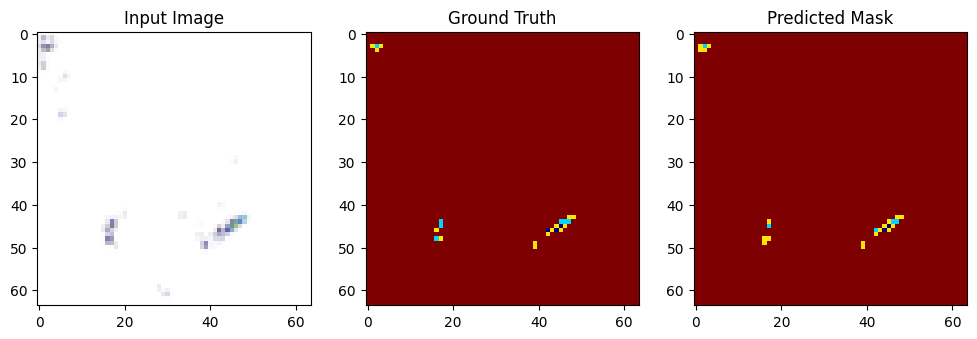

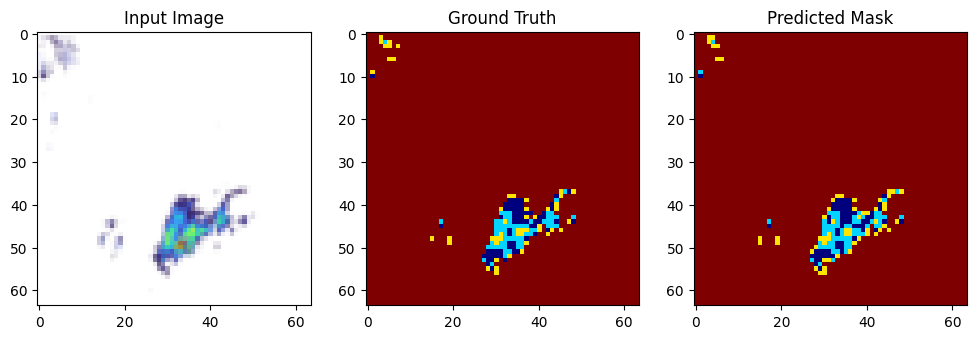

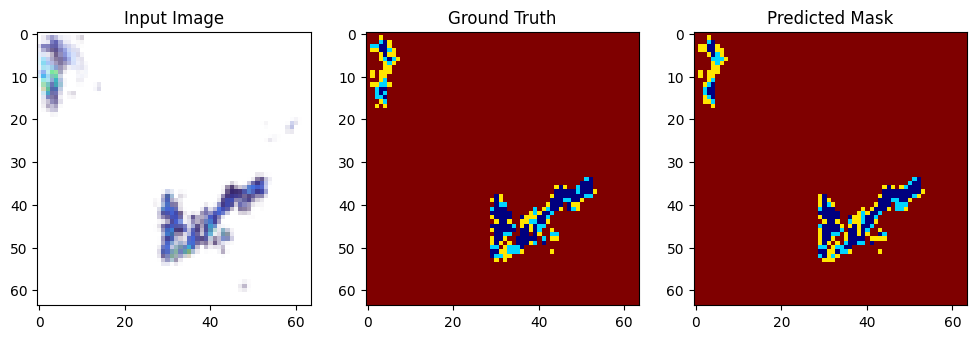

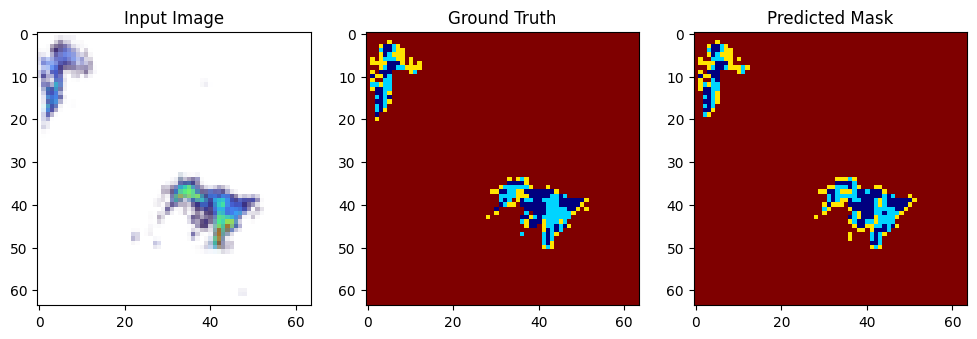

✅ Average Test Loss: 0.0006


In [5]:
import os
from glob import glob
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Setup paths and device
image_dir = '/kaggle/input/datalong2/long'  # Replace with your image directory
shapefile_path = '/kaggle/input/shapefile/us-state-boundaries.shp'  # Replace if needed

# Step 2: Check if image directory exists and contains images
image_paths = sorted(glob(os.path.join(image_dir, "*.png")))
if len(image_paths) == 0:
    raise ValueError(f"No images found in directory: {image_dir}")

# Step 3: Setup device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 4: Load the dataset and DataLoader
# Make sure PrecipSegDataset is already defined and accepts image_dir
train_dataset = PrecipSegDataset(image_dir=image_dir)
test_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False)

# Step 5: Define Test Function
def test_unet_segmentation(model, test_dataloader, device):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class segmentation
    total_loss = 0.0

    with torch.no_grad():
        for batch_idx, (images, masks, dates) in enumerate(test_dataloader):

            images = images.to(device)
            masks = masks.to(device)  # Ensure masks are in shape [B, H, W] (class indices)

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            if batch_idx == 0:
                visualize_batch_predictions(model, images, masks, device)
                break

    avg_loss = total_loss / len(test_dataloader)
    print(f"✅ Average Test Loss: {avg_loss:.4f}")

# Step 6: Visualization
def visualize_batch_predictions(model, images, true_masks, device):
    model.eval()
    with torch.no_grad():
        outputs = model(images.to(device))
        preds = torch.argmax(outputs, dim=1).cpu()  # Get the predicted class (highest probability)

    images = images.cpu() * 0.5 + 0.5  # If you normalized images with mean=0.5, std=0.5
    true_masks = true_masks.squeeze(1).cpu()

    num_samples = min(4, images.size(0))
    for i in range(num_samples):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title("Input Image")

        plt.subplot(1, 3, 2)
        plt.imshow(true_masks[i], cmap='jet')
        plt.title("Ground Truth")

        plt.subplot(1, 3, 3)
        plt.imshow(preds[i], cmap='jet')
        plt.title("Predicted Mask")
        plt.show()

# Step 7: Run test
test_unet_segmentation(model, test_dataloader, device)


In [6]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
!pip install geopandas rasterio shapely

In [15]:
!pip install rasterio

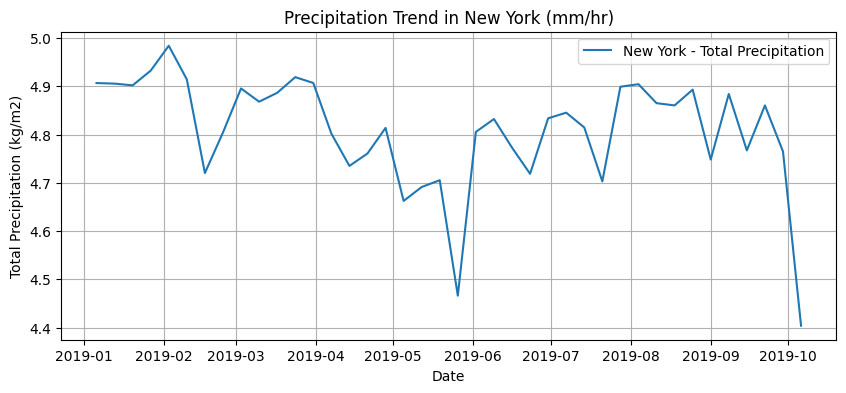

In [59]:


import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio import features
from shapely.geometry import box
import numpy as np
import rasterio

gdf = gpd.read_file('/kaggle/input/shapefile/us-state-boundaries.shp')

def rasterize_state_mask(state_geom, out_shape=(64, 64)):
    transform = rasterio.transform.from_bounds(*state_geom.bounds, out_shape[1], out_shape[0])
    mask = features.rasterize(
        [(state_geom, 1)],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        all_touched=True,
        dtype=np.uint8
    )
    return mask.astype(bool)
    
def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_dates = []

    with torch.no_grad():
        for images, _, dates in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.squeeze(1).cpu().numpy()  # [B, H, W]

            all_preds.extend(preds)  # Append each mask [H, W]
            all_dates.extend(dates)  # Append corresponding date

    return np.array(all_preds), all_dates

predicted_masks, prediction_dates = get_predictions(model, test_dataloader, device)



def extract_trends_by_state(predicted_masks, state_name):
    """
    Extract the total precipitation trend in mm/hr for a specific state.
    Each class (0, 1, 2, 3) corresponds to different levels of precipitation intensity in mm/hr.
    """
    # Precipitation intensities (in mm/hr) for each class
    class_intensities = {
        0: 0,   # No rain
        1: 2,   # Light rain
        2: 10,  # Moderate rain
        3: 25   # Heavy rain
    }
    
    # Assuming predicted_masks is a 4D array (Time x Height x Width x Channels)
    # and state_geom is the geometry of the region (state boundaries)
    
    state_geom = gdf[gdf['name'] == state_name].geometry.values[0]
    H, W = predicted_masks.shape[2:]  # Height and Width of the mask
    out_shape = (H, W)
    
    # Rasterize the state mask to match the predicted mask dimensions
    region_mask = rasterize_state_mask(state_geom, out_shape=out_shape)

    # Initialize the list to store total precipitation intensity for each time step
    total_precipitation_trend = []

    # Loop through the time steps and calculate the total precipitation trend in mm/hr

    trend_data = []

    # Loop through time steps
    for t in range(predicted_masks.shape[0]):  # Loop through time steps
        total_precipitation = 0

        # Loop through each class (0 to 3) representing different rain types
        for class_id in range(predicted_masks.shape[1]):  # Loop through each class (0 to 3)
           
            mask =np.clip( predicted_masks[t,class_id,:,:], 0, 1) # 1 for current class, else 0
            region_mask = region_mask.astype(bool)
            # Apply the region mask to focus on the state area
            masked_data = mask[region_mask]
            
           
            
            # Count how many pixels belong to the current class
            class_pixel_count = np.sum(masked_data)  # Count the pixels in this class
            if class_pixel_count < 0:
                print(f"Unexpected negative pixel count: {class_pixel_count}. Time: {t}, Class: {class_id}")
            # Use class intensity based on class id
            class_intensity = class_intensities[class_id]
          
            # Calculate total precipitation (number of pixels * intensity)
            total_precipitation += class_pixel_count * class_intensity  # Multiply by intensity in mm/hr
        
        trend_data.append(total_precipitation/10000)

    return trend_data

    
def plot_state_trend(state_name, trend_data, dates):
    """
    Plot the total precipitation trend for the specific state in mm/hr.
    """
    # Convert dates to pandas datetime
    dates = pd.to_datetime(dates, format='%Y%m%d%H')

    # Create a DataFrame for easier handling
    df = pd.DataFrame({
        'date': dates,
        'total_precipitation': trend_data
    })

    # Set the date column as the index for resampling
    df.set_index('date', inplace=True)

    # Resample by week and calculate the mean coverage for each week
    weekly_trend = df.resample('W').mean()

    # Plot the trend
    plt.figure(figsize=(10, 4))
    plt.plot(weekly_trend.index, weekly_trend['total_precipitation'], label=f"{state_name} - Total Precipitation")
    plt.xlabel("Date")
    plt.ylabel("Total Precipitation (kg/m2)")
    plt.title(f"Precipitation Trend in {state_name} (mm/hr)")
    plt.legend()
    plt.grid(True)
    plt.show()
# Get shape info
T, C, H, W = predicted_masks.shape


state_name = "New York"  # or any other name in your shapefile
trend = extract_trends_by_state(predicted_masks, state_name)
plot_state_trend(state_name, trend, prediction_dates)

def extract_region_data(images, region_mask):
    """
    Extract data from a specific region of interest from the images.
    """
    region_data = []
    for image in images:
        region_data.append(image[region_mask])  # Use the mask to extract region data
    
    return np.array(region_data)

def calculate_region_trends(region_data):
    """
    Calculate the trend over time for each region. This could be the average value.
    """
    # Calculate the mean value of the region over time (mean across time axis)
    region_trend = np.mean(region_data, axis=(1, 2))  # Mean across spatial dimensions
    
    return region_trend

def plot_region_trends(region_trends, dates):
    """
    Plot the trends for each region.
    """
    plt.plot(dates, region_trends, marker='o')
    plt.title('Precipitation Trend for Region')
    plt.xlabel('Date')
    plt.ylabel('Mean Precipitation')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Example usage
# Assuming you have image data and region masks (mask specific area)
# Extract precipitation data for the region (mask can be a boolean array for region selection)
region_mask = np.zeros((64, 64), dtype=bool)  # Example mask for a region (e.g., top-left)
region_mask[:32, :32] = True  # Mask a 32x32 area

# Extract data
#region_data = extract_region_data(images, region_mask)

# Calculate trend over time
#region_trend = calculate_region_trends(region_data)

# Plot the trend over time
#plot_region_trends(region_trend, dates)  # `dates` should correspond to the timestamps of images